# Imports

In [27]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt

Cloning into 'yolov5'...
remote: Enumerating objects: 8447, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (115/115), done.
remote: Total 8447 (delta 75), reused 95 (delta 46), pack-reused 8286
Receiving objects: 100% (8447/8447), 9.61 MiB | 18.57 MiB/s, done.
Resolving deltas: 100% (5815/5815), done.
/kaggle/working/yolov5/yolov5


In [28]:
%cd ..

/kaggle/working/yolov5


In [29]:
!pip install python-gdcm

In [30]:
! pip install transformers pytorch-lightning --quiet
! sudo apt -qq install git-lfs

/bin/bash: sudo: command not found


In [31]:
import pandas as pd
import numpy as np
# import pylibjpeg
import pydicom
from pydicom import dcmread
import gdcm
import matplotlib.pyplot as plt
import seaborn as sns

import ast
import cv2
import PIL
import glob
from tqdm.notebook import tqdm

import requests
import math
import shutil
from getpass import getpass
from PIL import Image, UnidentifiedImageError
from requests.exceptions import HTTPError
from io import BytesIO
from pathlib import Path
import torch
import torch.nn as nn
import albumentations as alb
import pytorch_lightning as pl
import torch.nn.functional as F
from huggingface_hub import HfApi, Repository
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from torchvision.datasets import ImageFolder
from transformers import ViTFeatureExtractor, ViTForImageClassification

# Helper

In [32]:
def plot(img):
    plt.figure(figsize=(10, 10))
    plt.title("Raw visualization")
    plt.imshow(img, 'gray')


def get_labels(df):
    for i, row in df.iterrows():
        if(row[labels[0]] == 1):
            df.loc[i, 'label']=labels[0]
        elif(row[labels[1]] == 1):
            df.loc[i, 'label']=labels[1]
        elif(row[labels[2]] == 1):
            df.loc[i, 'label']=labels[2]
        elif(row[labels[3]] == 1):
            df.loc[i, 'label']=labels[3]

In [33]:
def get_paths(df):
    list_, labels=[], []

    for i, path_ in tqdm(enumerate(df.path), total=len(df)):
        for folder in glob.glob(path_+'*'):
            list_.extend(glob.glob(folder+'/*.dcm'))
            labels.extend([df.iloc[i, 6] for _ in glob.glob(folder+'/*.dcm')])
            if(len(list_)!=len(labels)):
                print(len(list_),len(labels))
    return list_, labels


def convert_dicom(path):
    dicom = dcmread(path)
#     dicom = pydicom.read_file(path)
    return dicom.pixel_array

def augmentations(path, method='normal'):
    if method != 'cv':
#     ds = dcmread(path)
#     ds.PhotometricInterpretation = 'YBR_FULL'
#     img = ds.pixel_array
        simg = convert_dicom(path)
    
        aug = alb.Compose([
    #         alb.RandomBrightnessContrast(p=1),
    #         alb.RandomCrop(1200, 1200, always_apply=False, p=1.0),
    #         alb.CenterCrop(2000, 2000, always_apply=False, p=1.0),
            alb.Crop(x_min=300, y_min=300, x_max=800, y_max=800, always_apply=False, p=1.0),
            alb.Rotate(p=0.15),
    #         alb.Emboss(p=0.8),
    #         alb.Downscale(scale_min=0.1, scale_max=0.5,p=1),
    #         alb.Equalize(p=1),
    #         alb.RandomGamma(p=0.8),
        ])

        return aug(image=simg)['image']
    else:
        aug = alb.Compose([
            alb.Rotate(p=0.15),
            alb.Crop(x_min=300, y_min=300, x_max=800, y_max=800, always_apply=False, p=1.0),
        ])

        return aug(image=path)['image']

In [34]:
def scale_bbox(dim0, dim1, bboxes):
    # Get scaling factor
    scale_x = IMG_SIZE/dim1
    scale_y = IMG_SIZE/dim0
    
    scaled_bboxes = []
    for bbox in bboxes:
        x = int(np.round(bbox[0]*scale_x, 4))
        y = int(np.round(bbox[1]*scale_y, 4))
        x1 = int(np.round(bbox[2]*(scale_x), 4))
        y1= int(np.round(bbox[3]*scale_y, 4))

        scaled_bboxes.append([x, y, x1, y1]) # xmin, ymin, xmax, ymax
        
    return scaled_bboxes

def get_yolo_format_bbox(img_w, img_h, bboxes):
    yolo_boxes = []
    for bbox in bboxes:
        w = bbox[2] - bbox[0] # xmax - xmin
        h = bbox[3] - bbox[1] # ymax - ymin
        xc = bbox[0] + int(np.round(w/2)) # xmin + width/2
        yc = bbox[1] + int(np.round(h/2)) # ymin + height/2
        
        yolo_boxes.append([xc/img_w, yc/img_h, w/img_w, h/img_h]) # x_center y_center width height
    
    return yolo_boxes

# Data processing

In [38]:
study_level = pd.read_csv('../input/siim-covid19-detection/train_study_level.csv')
study_level.head()

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance
0,00086460a852_study,0,1,0,0
1,000c9c05fd14_study,0,0,0,1
2,00292f8c37bd_study,1,0,0,0
3,005057b3f880_study,1,0,0,0
4,0051d9b12e72_study,0,0,0,1


In [39]:
image_level = pd.read_csv("../input/siim-covid19-detection/train_image_level.csv")
image_level.head()

,id,boxes,label,StudyInstanceUID
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e


In [40]:
study_level['id'] = study_level.apply(lambda row: row.id.split('_')[0], axis=1)
study_level['path'] = study_level.apply(lambda row: "../input/siim-covid19-detection/train/"+row.id+'/', axis=1)

study_level.head(5)

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,path
0,00086460a852,0,1,0,0,../input/siim-covid19-detection/train/00086460...
1,000c9c05fd14,0,0,0,1,../input/siim-covid19-detection/train/000c9c05...
2,00292f8c37bd,1,0,0,0,../input/siim-covid19-detection/train/00292f8c...
3,005057b3f880,1,0,0,0,../input/siim-covid19-detection/train/005057b3...
4,0051d9b12e72,0,0,0,1,../input/siim-covid19-detection/train/0051d9b1...


In [41]:
labels = ['Negative for Pneumonia', 'Typical Appearance', 'Indeterminate Appearance', 'Atypical Appearance']
study_level['label']=''

get_labels(study_level)

In [42]:
study_level

,id,Negative for Pneumonia,Typical Appearance,Indeterminate Appearance,Atypical Appearance,path,label
0,00086460a852,0,1,0,0,../input/siim-covid19-detection/train/00086460...,Typical Appearance
1,000c9c05fd14,0,0,0,1,../input/siim-covid19-detection/train/000c9c05...,Atypical Appearance
2,00292f8c37bd,1,0,0,0,../input/siim-covid19-detection/train/00292f8c...,Negative for Pneumonia
3,005057b3f880,1,0,0,0,../input/siim-covid19-detection/train/005057b3...,Negative for Pneumonia
4,0051d9b12e72,0,0,0,1,../input/siim-covid19-detection/train/0051d9b1...,Atypical Appearance
...,...,...,...,...,...,...,...
6049,ffcb4630f46f,0,1,0,0,../input/siim-covid19-detection/train/ffcb4630...,Typical Appearance
6050,ffe4d6e8fbb0,0,1,0,0,../input/siim-covid19-detection/train/ffe4d6e8...,Typical Appearance
6051,ffe94fcb14fa,0,1,0,0,../input/siim-covid19-detection/train/ffe94fcb...,Typical Appearance
6052,ffebf1ef4a9c,0,1,0,0,../input/siim-covid19-detection/train/ffebf1ef...,Typical Appearance


In [43]:
for i, row in tqdm(image_level.iterrows(), total=len(image_level)):
    uid = row.StudyInstanceUID
    for folder in glob.glob('../input/siim-covid19-detection/train/' + uid + '/*'):
        for file in glob.glob(folder + '/*'):
#             if file.split('/')[-1] == row.id.split('_')[0] + '.dcm':
                image_level.loc[i, 'image_path'] = file
                image_level.loc[i, 'image_label'] = study_level[study_level['id']==uid].label.values[0]

  0%|          | 0/6334 [00:00<?, ?it/s]

In [44]:
image_level

,id,boxes,label,StudyInstanceUID,image_path,image_label
0,000a312787f2_image,"[{'x': 789.28836, 'y': 582.43035, 'width': 102...",opacity 1 789.28836 582.43035 1815.94498 2499....,5776db0cec75,../input/siim-covid19-detection/train/5776db0c...,Typical Appearance
1,000c3a3f293f_image,NaN,none 1 0 0 1 1,ff0879eb20ed,../input/siim-covid19-detection/train/ff0879eb...,Negative for Pneumonia
2,0012ff7358bc_image,"[{'x': 677.42216, 'y': 197.97662, 'width': 867...",opacity 1 677.42216 197.97662 1545.21983 1197....,9d514ce429a7,../input/siim-covid19-detection/train/9d514ce4...,Typical Appearance
3,001398f4ff4f_image,"[{'x': 2729, 'y': 2181.33331, 'width': 948.000...",opacity 1 2729 2181.33331 3677.00012 2785.33331,28dddc8559b2,../input/siim-covid19-detection/train/28dddc85...,Atypical Appearance
4,001bd15d1891_image,"[{'x': 623.23328, 'y': 1050, 'width': 714, 'he...",opacity 1 623.23328 1050 1337.23328 2156 opaci...,dfd9fdd85a3e,../input/siim-covid19-detection/train/dfd9fdd8...,Typical Appearance
...,...,...,...,...,...,...
6329,ffcc6edd9445_image,NaN,none 1 0 0 1 1,7e6c68462e06,../input/siim-covid19-detection/train/7e6c6846...,Negative for Pneumonia
6330,ffd91a2c4ca0_image,NaN,none 1 0 0 1 1,8332bdaddb6e,../input/siim-covid19-detection/train/8332bdad...,Negative for Pneumonia
6331,ffd9b6cf2961_image,"[{'x': 2197.38566, 'y': 841.07361, 'width': 31...",opacity 1 2197.38566 841.07361 2513.80265 1292...,7eed9af03814,../input/siim-covid19-detection/train/7eed9af0...,Typical Appearance
6332,ffdc682f7680_image,"[{'x': 2729.27083, 'y': 332.26044, 'width': 14...",opacity 1 2729.27083 332.26044 4225.52099 2936...,a0cb0b96fb3d,../input/siim-covid19-detection/train/a0cb0b96...,Typical Appearance


# Detection

In [45]:
image_level.boxes = image_level.boxes.fillna(0)

In [46]:
IMG_SIZE = 2500
# Get bboxes
bboxes = [[789.28836, 582.43035, 1026.65662, 1917.30292]]
# Scale bounding boxes
scale_bboxes = scale_bbox(3488, 4256, bboxes)
# Format for YOLOv5
yolo_bboxes = get_yolo_format_bbox(2500, 2500, scale_bboxes)
yolo_bboxes

[[0.2132, 0.358, 0.056, 0.3828]]

In [47]:
b = yolo_bboxes[0]
xc, yc = int(np.round(b[0]*2500)), int(np.round(b[1]*2500))
w, h = int(np.round(b[2]*2500)), int(np.round(b[3]*2500))

xmin = xc - int(np.round(w/2))
xmax = xc + int(np.round(w/2))
ymin = yc - int(np.round(h/2))
ymax = yc + int(np.round(h/2))
print(xmin, xmax, ymin, ymax)

463 603 417 1373


(3488, 4256)


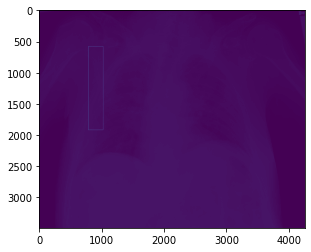

In [48]:
from PIL import Image, ImageDraw
img = convert_dicom(image_level.image_path.values[0])
img = Image.fromarray(img)
img1 = ImageDraw.Draw(img)  
img1.rectangle( [(789.28836, 582.43035), (1026.65662, 1917.30292)])
# img.show()
img = np.array(img)
# img = img[500:500+2500, 500:500+2500]
plt.imshow(img)
print(img.shape)

(2500, 2500)


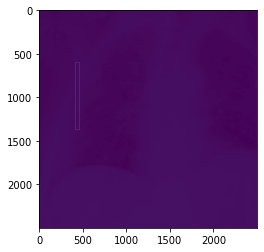

In [49]:
from PIL import Image, ImageDraw
img = convert_dicom(image_level.image_path.values[0])
img = img[500:500+2500, 500:500+2500]
img = Image.fromarray(img)
img1 = ImageDraw.Draw(img)  
img1.rectangle( [(463,603), (417,1373)])
# img.show()
img = np.array(img)
plt.imshow(img)
print(img.shape)

In [50]:
!mkdir data
%cd data
!mkdir train
!mkdir valid
%cd train
!mkdir images
!mkdir labels
%cd ..
%cd valid
!mkdir images
!mkdir labels
%cd ..
%cd ..

mkdir: cannot create directory ‘data’: File exists
/kaggle/working/data
mkdir: cannot create directory ‘train’: File exists
mkdir: cannot create directory ‘valid’: File exists
/kaggle/working/data/train
mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘labels’: File exists
/kaggle/working/data
/kaggle/working/data/valid
mkdir: cannot create directory ‘images’: File exists
mkdir: cannot create directory ‘labels’: File exists
/kaggle/working/data
/kaggle/working


In [51]:
from sklearn.model_selection import train_test_split

image_level = image_level[image_level['boxes']!=0].iloc[:500, :]
train_images, valid_images, train_labels, valid_labels=train_test_split(
                                                        image_level.image_path.values,
                                                        image_level.boxes.values,
                                                        test_size=0.1) 
traini = "./data/valid/images/"
trainl = "./data/valid/labels/"
for image, label in tqdm(zip(valid_images, valid_labels), total=len(valid_images)):
    img = convert_dicom(image)
#     retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TOZERO_INV)
    dim0, dim1 = img.shape
    threshold = img[500:500+2500, 500:500+2500]
    name = image.split('/')[-1].replace('dcm', 'jpg')
    cv2.imwrite(traini+name , threshold)
    
    if label == 0:
        continue
    else:
        label = ast.literal_eval(label)
        for box in label:
            xmin = box['x']
            ymin = box['y']
            w = box['width']
            h = box['height']
            bboxes = [[xmin, ymin, w, h]]
            scale_bboxes = scale_bbox(dim0, dim1, bboxes)
            yolo_bboxes = get_yolo_format_bbox(2500, 2500, scale_bboxes)[0]
        with open(trainl + name.replace('jpg', 'txt'), "w") as f:
            f.write('%d %f %f %f %f' %(1,yolo_bboxes[0],yolo_bboxes[1],yolo_bboxes[2],yolo_bboxes[3]) + '\n')
            
traini = "./data/train/images/"
trainl = "./data/train/labels/"
for image, label in tqdm(zip(train_images, train_labels), total=len(train_images)):
    img = convert_dicom(image)
#     retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TOZERO_INV)
    dim0, dim1 = img.shape
    threshold = img[500:500+2500, 500:500+2500]
    name = image.split('/')[-1].replace('dcm', 'jpg')
    cv2.imwrite(traini+name , threshold)
    
    if label == 0:
        continue
    else:
        label = ast.literal_eval(label)
        for box in label:
            xmin = box['x']
            ymin = box['y']
            w = box['width']
            h = box['height']
            bboxes = [[xmin, ymin, w, h]]
            scale_bboxes = scale_bbox(dim0, dim1, bboxes)
            yolo_bboxes = get_yolo_format_bbox(2500, 2500, scale_bboxes)[0]
        with open(trainl + name.replace('jpg', 'txt'), "w") as f:
            f.write('%d %f %f %f %f' %(1,yolo_bboxes[0],yolo_bboxes[1],yolo_bboxes[2],yolo_bboxes[3]) + '\n')

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/450 [00:00<?, ?it/s]

In [52]:
import yaml, os

data_yaml = dict(
    train = "../data/train/",
    val = "../data/valid/",
    nc = 2,
    names = ['none', 'opacity']
)

# Note that I am creating the file in the yolov5/data/ directory.

with open('./yolov5/data/data.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)
    
%cat ./yolov5/data/data.yaml

{names: [none, opacity], nc: 2, train: ../data/train/, val: ../data/valid/}


In [ ]:
%cd ./yolov5/

In [25]:
!pip install -q --upgrade wandb
# Login 
import wandb
wandb.login()

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.5.0 requires wandb<0.11.0,>=0.10.0, but you have wandb 0.11.0 which is incompatible.


wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter:  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [26]:
!python train.py --img {2500} \
                 --batch {2} \
                 --epochs {2} \
                 --data data.yaml \
                 --weights yolov5m.pt \
                 --save_period 1\
                 --project covid19-detection-kaggle

train: weights=yolov5m.pt, cfg=, data=data.yaml, hyp=data/hyps/hyp.scratch.yaml, epochs=2, batch_size=2, imgsz=2500, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, evolve=None, bucket=, cache_images=False, image_weights=False, device=, multi_scale=False, single_cls=False, adam=False, sync_bn=False, workers=8, project=covid19-detection-kaggle, entity=None, name=exp, exist_ok=False, quad=False, linear_lr=False, label_smoothing=0.0, upload_dataset=False, bbox_interval=-1, save_period=1, artifact_alias=latest, local_rank=-1
github: up to date with https://github.com/ultralytics/yolov5 ✅
2021-07-27 13:25:41.751958: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-07-27 13:25:41.752040: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do no

# Classification

# Image and label segregation

In [53]:
train_images_path, train_images_labels = get_paths(study_level)
len(train_images_path), len(train_images_labels)

  0%|          | 0/6054 [00:00<?, ?it/s]

(6334, 6334)

In [54]:
train_images_path[0], train_images_labels[0]

('../input/siim-covid19-detection/train/00086460a852/9e8302230c91/65761e66de9f.dcm',
 'Typical Appearance')

# Image level segregation

In [55]:
train_images_path, train_images_labels = image_level.image_path, image_level.image_label
len(train_images_path), len(train_images_labels)

(500, 500)

# Class Distribution

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Negative for Pneumonia', ylabel='count'>

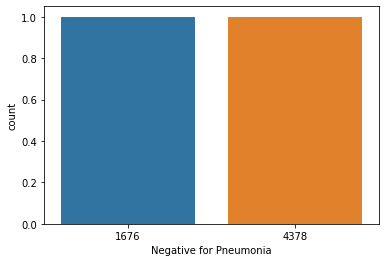

In [56]:
sns.countplot(study_level['Negative for Pneumonia'].value_counts())

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Typical Appearance', ylabel='count'>

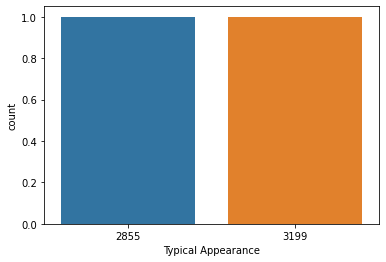

In [57]:
sns.countplot(study_level['Typical Appearance'].value_counts())

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Indeterminate Appearance', ylabel='count'>

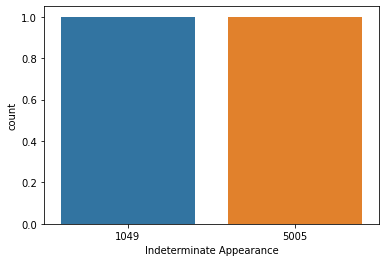

In [58]:
sns.countplot(study_level['Indeterminate Appearance'].value_counts())

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='Atypical Appearance', ylabel='count'>

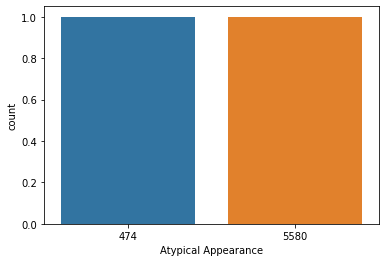

In [59]:
sns.countplot(study_level['Atypical Appearance'].value_counts())

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


<AxesSubplot:xlabel='label', ylabel='count'>

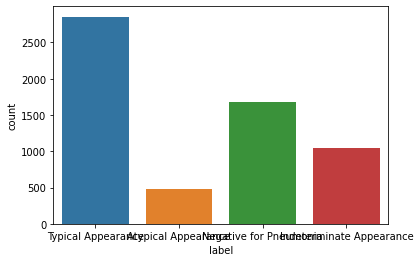

In [60]:
sns.countplot(study_level.label)

# Image Visualization

Typical Appearance


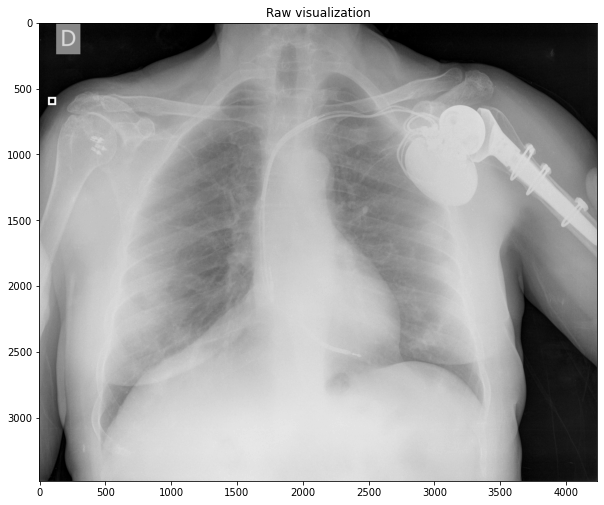

In [61]:
dicom = dcmread(train_images_path[100])
img = dicom.pixel_array
plot(img)

print(train_images_labels[100])

# Feature Extraction

## Albumentations

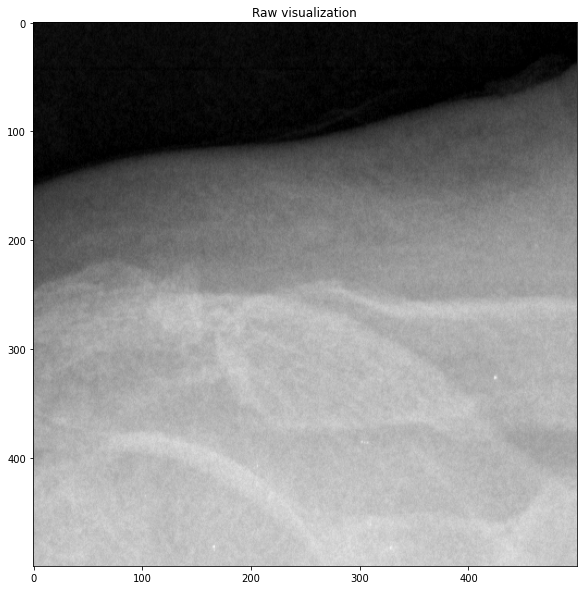

In [62]:
img = augmentations(train_images_path[100])
plot(np.array(img))

## OpenCV Image Threshold

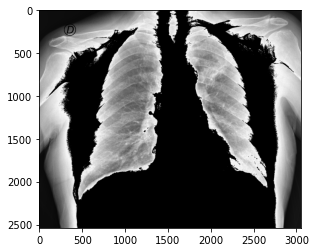

In [63]:
img = convert_dicom(train_images_path[5])
retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TOZERO_INV)
plt.imshow(threshold, "gray")

In [64]:
cv2.imwrite("./sample.jpg", threshold)

True

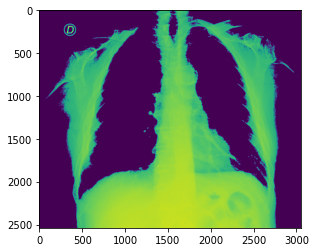

In [65]:
img = convert_dicom(train_images_path[5])
retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TOZERO)
plt.imshow(threshold)

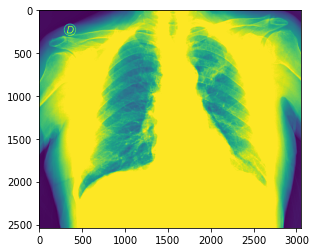

In [66]:
img = convert_dicom(train_images_path[5])
retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TRUNC)
plt.imshow(threshold)

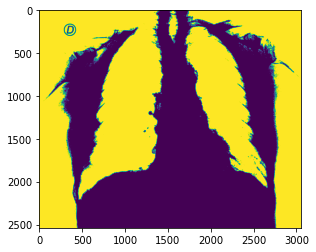

In [67]:
img = convert_dicom(train_images_path[5])
retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_BINARY_INV)
plt.imshow(threshold)

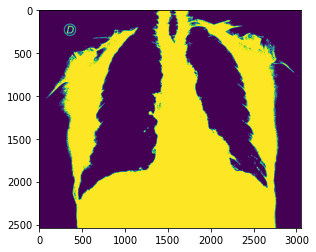

In [68]:
img = convert_dicom(train_images_path[5])
retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_BINARY)
plt.imshow(threshold)

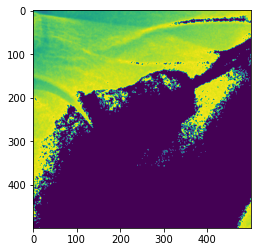

In [69]:
img = convert_dicom(train_images_path[5])
retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TOZERO_INV)
img = augmentations(threshold, method='cv')
plt.imshow(img)

## Normal Deep 2D Convolution

In [70]:
class FeatureExtractor(nn.Module):
    def __init__(self, fil1, fil2, fil3):
        super(FeatureExtractor, self).__init__()
        self.conv1 = nn.Conv2d(1, 1, fil1)
        self.conv2 = nn.Conv2d(1, 1, fil2)
        self.conv3 = nn.Conv2d(1, 1, fil3)
        
    def forward(self, img):
        img = self.conv1(img)
        img = self.conv2(img)
        img = self.conv3(img)
        return img
    
model = FeatureExtractor(15, 30, 3)

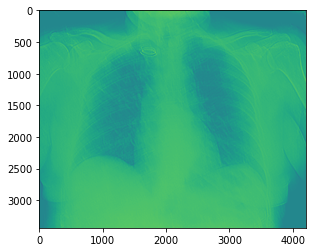

In [71]:
img = convert_dicom(train_images_path[10])
img = torch.Tensor(img.astype('float32')).unsqueeze(0).unsqueeze(0)
plt.imshow(model(img).squeeze(0).squeeze(0).squeeze(0).detach().numpy())

# Classification on Study_level

In [72]:
from sklearn.model_selection import train_test_split

train_images, valid_images, train_labels, valid_labels=train_test_split(
                                                        train_images_path.values,
                                                        train_images_labels.values,
                                                        test_size=0.2) 

In [81]:
train_path = "./data/train/images/"
for image, label in tqdm(zip(train_images, train_labels), total=len(train_images)):
    img = convert_dicom(image)
    retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TOZERO_INV)
    cv2.imwrite(train_path + image.split('/')[-1].replace('dcm', 'jpg'), threshold)

In [75]:
train_images[0], train_labels[0]

('../input/siim-covid19-detection/train/00b33b3eb8d9/6c8b814c685b/12a2dfb55b6f.dcm',
 'Typical Appearance')

In [82]:
label_map = {'Atypical Appearance':0,
            'Indeterminate Appearance':1,
            'Negative for Pneumonia':2,
            'Typical Appearance':3}
label_id = {0:'Atypical Appearance',
            1:'Indeterminate Appearance',
            2:'Negative for Pneumonia',
            3:'Typical Appearance'}

In [83]:
class CovidDataset(Dataset):
    def __init__(self, images, labels, label_map, transform):
        super(CovidDataset, self).__init__()
        self.images=images
        self.labels=labels
        self.label_map=label_map
        self.transform=transform
        
    def __len__(self):
        return len(self.images)
    
    def __getitem__(self, idx):
        img = convert_dicom(self.images[idx])
        img = img[500:500+800, 500:500+800]
        retval, threshold = cv2.threshold(img, 2500, 255, cv2.THRESH_TOZERO_INV)
        fimg = img.astype('float32')# np.array(img, dtype=np.float32)
        label = self.label_map[self.labels[idx]]
        
        return {
            'image':torch.tensor(fimg).unsqueeze(0),
            'label':torch.tensor(label)
        }

In [84]:
train_dataset = CovidDataset(train_images, train_labels, label_map, augmentations)
val_dataset = CovidDataset(valid_images, valid_labels, label_map, augmentations)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
valid_loader = DataLoader(val_dataset, batch_size=32, shuffle=True, num_workers=2)

In [85]:
class Model(nn.Module):
    def __init__(self, units):
        super(Model, self).__init__()
        self.f1 = nn.Linear(3*2500*2500, units)
        self.output = nn.Linear(units, 4)
        
        
    def forward(self, img):
        img = torch.flatten(img, 1)
        img = F.relu(self.f1(img))
        img = self.output(img)
        return img
    
model = Model(16)

In [86]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(1):

    model.to('cuda')
    model.train()
    running_loss = 0.0
    for i, data in tqdm(enumerate(train_loader, 0), total=len(train_loader)):
        inputs, labels = data['image'], data['label']
        inputs = inputs.to('cuda')
        labels = labels.to('cuda')
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 20 == 19:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0

print('Finished Training')

In [ ]:
for i, data in enumerate(valid_loader):
    inputs, labels = data['image'], data['label']
    inputs = inputs.to('cpu')
    labels = labels.to('cpu')
    with torch.no_grad():
        model.eval()
        model.to("cpu")
        output = model(inputs)
        print(output.max(1)[1], labels)

# Vision Transformer

In [ ]:
# label2id = {}
# id2label = {}

# for i, class_name in enumerate(ds.classes):
#     label2id[class_name] = str(i)
#     id2label[str(i)] = class_name

In [ ]:
# class ImageClassificationCollator:
#     def __init__(self, feature_extractor):
#         self.feature_extractor = feature_extractor
 
#     def __call__(self, batch):
#         encodings = self.feature_extractor([x[0] for x in batch], return_tensors='pt')
#         encodings['labels'] = torch.tensor([x[1] for x in batch], dtype=torch.long)
#         return encodings 

In [ ]:
# feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')
# model = ViTForImageClassification.from_pretrained(
#     'google/vit-base-patch16-224-in21k',
#     num_labels=len(label2id),
#     label2id=label2id,
#     id2label=id2label
# )
# collator = ImageClassificationCollator(feature_extractor)
# train_loader = DataLoader(train_ds, batch_size=8, collate_fn=collator, num_workers=2, shuffle=True)
# val_loader = DataLoader(val_ds, batch_size=8, collate_fn=collator, num_workers=2)

In [ ]:
# class Classifier(pl.LightningModule):

#     def __init__(self, model, lr: float = 2e-5, **kwargs):
#         super().__init__()
#         self.save_hyperparameters('lr', *list(kwargs))
#         self.model = model
#         self.forward = self.model.forward
#         self.val_acc = Accuracy()

#     def training_step(self, batch, batch_idx):
#         outputs = self(**batch)
#         self.log(f"train_loss", outputs.loss)
#         return outputs.loss

#     def validation_step(self, batch, batch_idx):
#         outputs = self(**batch)
#         self.log(f"val_loss", outputs.loss)
#         acc = self.val_acc(outputs.logits.argmax(1), batch['labels'])
#         self.log(f"val_acc", acc, prog_bar=True)
#         return outputs.loss

#     def configure_optimizers(self):
#         return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [ ]:
# pl.seed_everything(42)
# classifier = Classifier(model, lr=2e-5)
# trainer = pl.Trainer(gpus=1, precision=16, max_epochs=4)
# trainer.fit(classifier, train_loader, val_loader)

In [ ]:
# val_batch = next(iter(val_loader))
# outputs = model(**val_batch)
# print('Preds: ', outputs.logits.softmax(1).argmax(1))
# print('Labels:', val_batch['labels'])